# 1. Полносвязные сети (многослойный персептрон)
Решите задачу классификации на данных, с которыми вы работали в лабораторной No 2,
результат сравните с полученными ранее

# 2. Сверточные сети
Решите любую задачу по вашему выбору, обязательным условием является только
использование сверточных слоев (например задачу классификации изображений(если в
выбранном датасете много классов, достаточно оставить например 5), или генерации с
помощью GAN)

# 3. Рекуррентные сети
Решите любую задачу по вашему выбору, обязательным условием является только
использование рекуррентной сети (это может быть предсказание значений временного
ряда или задача классификации текстов)

Датасеты для задания No 2 (MNIST и CIFAR-10 не использовать) можно брать отсюда:
https://www.kaggle.com/tags/image-data
Для задания No 3
временные ряды:
https://www.kaggle.com/tags/time-series
тексты можно брать те же, что и в лабораторной No 3

# MLP PyTorch

In [310]:
import os
import numpy as np 
import pandas as pd


In [311]:
PATH = r"C:\Users\malin\Desktop\Универ\Data Analysis\Lc\LAb2\datasets"

In [504]:
data = pd.read_csv(PATH + "\mushrooms.csv")
for cat in data.columns:
    data[cat] = data[cat].astype("category")
target = data['class']
data.drop('class',axis = 1,inplace = True)
data.head(5)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [563]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cap-shape                 8124 non-null   category
 1   cap-surface               8124 non-null   category
 2   cap-color                 8124 non-null   category
 3   bruises                   8124 non-null   category
 4   odor                      8124 non-null   category
 5   gill-attachment           8124 non-null   category
 6   gill-spacing              8124 non-null   category
 7   gill-size                 8124 non-null   category
 8   gill-color                8124 non-null   category
 9   stalk-shape               8124 non-null   category
 10  stalk-root                8124 non-null   category
 11  stalk-surface-above-ring  8124 non-null   category
 12  stalk-surface-below-ring  8124 non-null   category
 13  stalk-color-above-ring    8124 non-null   catego

In [562]:
isNA = [data[i].isna().unique() for i in data.columns]
print(isNA)

[array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False])]


In [475]:
cat_data = [np.array(data[i].cat.codes) for i in data.columns]
cat_data_s  = np.stack([*np.array(cat_data)],1)
cat_data_pd = pd.DataFrame(cat_data_s)

In [525]:
target = target.astype("category").cat.codes.values
categorical_column_sizes = [len(cat_data_pd[column].astype("category").cat.categories) for column in cat_data_pd.columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

In [212]:
from sklearn.model_selection import train_test_split
import torch

In [507]:
X_train,X_test,Y_train,Y_test = train_test_split(cat_data_pd,target,test_size = 0.3)

In [508]:
categorical_train_data = torch.tensor(np.array(X_train),dtype = torch.int64)
categorical_test_data = torch.tensor(np.array(X_test),dtype = torch.int64)

categorical_train_target = torch.tensor(np.array(Y_train).flatten(),dtype = torch.int64)
categorical_test_target = torch.tensor(np.array(Y_test).flatten(),dtype = torch.int64)

In [518]:
import torch.nn as nn
import torch.nn.functional as f

class Model(nn.Module):#MultiLayer Perceptron
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size =  num_categorical_cols 

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_categorical):
        embeddings = []
        
        for i, e in enumerate(self.all_embeddings):
            #%debug
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [553]:
model = Model(categorical_embedding_sizes,2,[200,100,50],p = 0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(4, 2)
    (2): Embedding(10, 5)
    (3): Embedding(2, 1)
    (4): Embedding(9, 5)
    (5): Embedding(2, 1)
    (6): Embedding(2, 1)
    (7): Embedding(2, 1)
    (8): Embedding(12, 6)
    (9): Embedding(2, 1)
    (10): Embedding(5, 3)
    (11): Embedding(4, 2)
    (12): Embedding(4, 2)
    (13): Embedding(9, 5)
    (14): Embedding(9, 5)
    (15): Embedding(1, 1)
    (16): Embedding(4, 2)
    (17): Embedding(3, 2)
    (18): Embedding(5, 3)
    (19): Embedding(9, 5)
    (20): Embedding(6, 3)
    (21): Embedding(7, 4)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=100, out_features=50, bias=True

In [554]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epoch = 300
aggregated_loss = []

for i in range(epoch):
    i += 1
    y_pred = model(categorical_train_data)
    single_loss = loss_function(y_pred,categorical_train_target)
    aggregated_loss.append(single_loss)
    
    if i%25 == 1:
        print(f"Значение функции потерь :  {single_loss.item():10.8f} | Epoch : {i}")
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
print(f"Финал : {single_loss} ")

Значение функции потерь :  0.69948924 | Epoch : 1
Значение функции потерь :  0.21378130 | Epoch : 26
Значение функции потерь :  0.11715830 | Epoch : 51
Значение функции потерь :  0.07307478 | Epoch : 76
Значение функции потерь :  0.04944579 | Epoch : 101
Значение функции потерь :  0.04201740 | Epoch : 126
Значение функции потерь :  0.03661250 | Epoch : 151
Значение функции потерь :  0.02619268 | Epoch : 176
Значение функции потерь :  0.02843243 | Epoch : 201
Значение функции потерь :  0.01997202 | Epoch : 226
Значение функции потерь :  0.02213849 | Epoch : 251
Значение функции потерь :  0.02313596 | Epoch : 276
Финал : 0.01585538126528263 


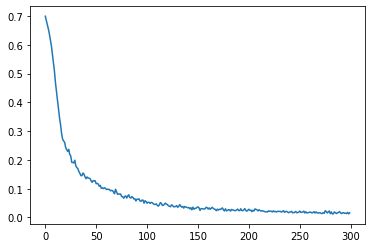

In [555]:
plt.plot(range(epoch),aggregated_loss)# test loss

In [522]:
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, categorical_test_target)
print(f'Ошибка на тестовом наборе: {loss:.8f}')

Ошибка на тестовом наборе: 0.01091461


# CNN Classification tensorflow

In [527]:
import numpy as np
import keras
import cv2
import os
import sys
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [531]:
from keras.preprocessing.image import ImageDataGenerator

In [538]:
train_dir = "./dogs_cats_small/train"
test_dir = "./dogs_cats_small/test"

In [529]:
ImSize = 64
input_shape = (ImSize, ImSize, 3)
batch_size = 32

In [539]:
train_datagen = ImageDataGenerator(rescale=1.0/255, #shear_range=0.1, 
                                    #rotation_range=10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1, 
                                    fill_mode = "constant")
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [540]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                target_size=(ImSize, ImSize), 
                batch_size = batch_size)
test_generator = test_datagen.flow_from_directory(test_dir, 
                    target_size=(ImSize, ImSize), batch_size=1,
                    shuffle = False)

Found 1600 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [541]:
from keras.layers import Conv2D, MaxPool2D, Flatten, \
Dense, Dropout, BatchNormalization

In [542]:
model = keras.models.Sequential()
model.add(Conv2D(64, (3,3), padding="same", activation='relu',
                 input_shape = input_shape))
model.add(MaxPool2D())
model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3,3), padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(512, (3,3), padding="same", activation='relu'))
model.add(MaxPool2D((8,8)))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [543]:
model.compile(keras.optimizers.Adam(lr=0.001), 
              loss = keras.losses.categorical_crossentropy, 
             metrics = ['accuracy'])

In [544]:
model.fit_generator(train_generator, 
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs = 30)

Epoch 1/30
50/50 [==============================] - 29s 577ms/step - loss: 0.7020 - accuracy: 0.4938
Epoch 2/30
50/50 [==============================] - 21s 423ms/step - loss: 0.6920 - accuracy: 0.5250
Epoch 3/30
50/50 [==============================] - 21s 429ms/step - loss: 0.6814 - accuracy: 0.5669
Epoch 4/30
50/50 [==============================] - 22s 439ms/step - loss: 0.6687 - accuracy: 0.5944
Epoch 5/30
50/50 [==============================] - 24s 478ms/step - loss: 0.6610 - accuracy: 0.5956
Epoch 6/30
50/50 [==============================] - 23s 455ms/step - loss: 0.6271 - accuracy: 0.6550
Epoch 7/30
50/50 [==============================] - 22s 440ms/step - loss: 0.6218 - accuracy: 0.6569
Epoch 8/30
50/50 [==============================] - 22s 448ms/step - loss: 0.5886 - accuracy: 0.6844
Epoch 9/30
50/50 [==============================] - 22s 441ms/step - loss: 0.5818 - accuracy: 0.6844
Epoch 10/30
50/50 [==============================] - 23s 458ms/step - loss: 0.5774 - accura

In [546]:
score = model.evaluate_generator(test_generator, steps = test_generator.n)

In [550]:
print(f"test {model.metrics_names[0]} : {score[0]} | test {model.metrics_names[1]} : {score[1]}")

test loss : 0.0329279899597168 | test accuracy : 0.7487804889678955


# LSTM TimeSeries Forecasting PyTorch

In [613]:
data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")

In [623]:
data1 = pd.DataFrame(data)

In [968]:
data1.T.head() ## W - Week | P - Product

,0,1,2,3,4,5,6,7,8,9,...,801,802,803,804,805,806,807,808,809,810
Product_Code,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P810,P811,P812,P813,P814,P815,P816,P817,P818,P819
W0,11,7,7,12,8,3,4,8,14,22,...,0,5,3,1,4,0,0,1,0,0
W1,12,6,11,8,5,3,8,6,9,19,...,0,1,2,1,2,0,1,0,0,1
W2,10,3,8,13,13,2,3,10,10,19,...,1,3,0,1,2,1,0,0,0,0
W3,8,2,9,5,11,7,7,9,7,29,...,0,5,0,3,6,0,0,0,1,0


In [963]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Columns: 107 entries, Product_Code to Normalized 51
dtypes: float64(52), int64(54), object(1)
memory usage: 678.1+ KB


In [640]:
data1.describe()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,...,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.00000,811.000000,811.000000,811.000000
mean,8.902589,9.129470,9.389642,9.717633,9.574599,9.466091,9.720099,9.585697,9.784217,9.681874,...,0.299149,0.287571,0.304846,0.316017,0.334760,0.314636,0.33815,0.358903,0.373009,0.427941
std,12.067163,12.564766,13.045073,13.553294,13.095765,12.823195,13.347375,13.049138,13.550237,13.137916,...,0.266993,0.256630,0.263396,0.262226,0.275203,0.266029,0.27569,0.286665,0.295197,0.342360
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.020000,0.085000,0.000000,0.10500,0.100000,0.110000,0.090000
50%,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,...,0.280000,0.270000,0.300000,0.310000,0.330000,0.310000,0.33000,0.330000,0.350000,0.430000
75%,12.000000,12.000000,12.000000,13.000000,13.000000,12.500000,13.000000,12.500000,13.000000,13.000000,...,0.490000,0.450000,0.500000,0.500000,0.500000,0.500000,0.50000,0.550000,0.560000,0.670000
max,54.000000,53.000000,56.000000,59.000000,61.000000,52.000000,56.000000,62.000000,63.000000,52.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [680]:
ind = [data1.columns[i] for i in range(len(data1.columns)) if ("W" not in  data1.columns[i]) == True ]

In [ ]:
normal_data = data1.drop(['Product_Code'],axis = 1)[ind[3:]].T
data_train = normal_data[range(20)][:45]
data_test  = data1.drop(['Product_Code'],axis = 1).T[range(20)][45:52]

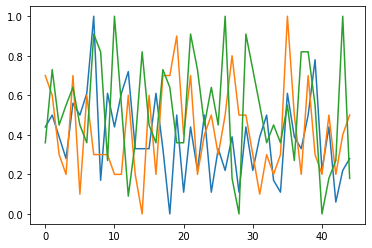

In [820]:
plt.plot(range(45),data_train[[0,1,2]])

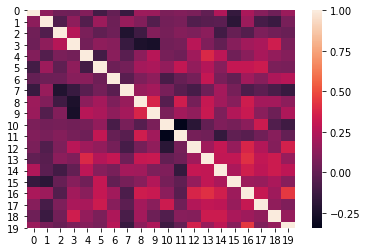

In [965]:
import seaborn as sns 
sns.heatmap(data_train.corr())

In [966]:
data_train_normalized = torch.FloatTensor(np.array(data_train))

In [761]:
train_window = 4 ## a month

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [762]:
train_inout_seq = create_inout_sequences(data_train_normalized, train_window)

In [791]:
class LSTM(nn.Module):
    def __init__(self, input_size= 20, hidden_layer_size=200, output_size=20):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [792]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [786]:
print(model)

LSTM(
  (lstm): LSTM(20, 200)
  (linear): Linear(in_features=200, out_features=20, bias=True)
)


In [783]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

C:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 20])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.03278933
epoch:  26 loss: 0.02544103
epoch:  51 loss: 0.00322549
epoch:  76 loss: 0.00068861
epoch: 101 loss: 0.00193814
epoch: 126 loss: 0.00137959
epoch: 149 loss: 0.0011753625


In [795]:
fut_pred = 4

test_inputs = data_train_normalized[-train_window:].tolist()
print(test_inputs)

[[0.4399999976158142, 0.5, 0.18000000715255737, 0.23999999463558197, 0.33000001311302185, 0.36000001430511475, 0.800000011920929, 0.5, 0.33000001311302185, 0.33000001311302185, 0.4399999976158142, 0.4399999976158142, 0.20999999344348907, 0.18000000715255737, 0.36000001430511475, 0.3799999952316284, 0.3100000023841858, 0.6800000071525574, 0.07000000029802322, 0.4699999988079071], [0.05999999865889549, 0.20000000298023224, 0.27000001072883606, 0.4099999964237213, 0.27000001072883606, 0.36000001430511475, 0.20000000298023224, 0.5799999833106995, 0.5299999713897705, 0.20999999344348907, 0.3799999952316284, 0.4399999976158142, 0.20999999344348907, 0.5, 0.5799999833106995, 0.5600000023841858, 0.5400000214576721, 0.36000001430511475, 0.4099999964237213, 0.33000001311302185], [0.2199999988079071, 0.4000000059604645, 1.0, 0.4699999988079071, 0.5299999713897705, 0.18000000715255737, 0.30000001192092896, 0.9200000166893005, 0.12999999523162842, 0.33000001311302185, 0.6899999976158142, 0.219999998

In [821]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
    
        test_inputs.append(model(seq))

In [822]:
test_inputs[fut_pred:]

[tensor([-0.0503, -0.0019, -0.0026, -0.0325, -0.0482, -0.0650, -0.0378,  0.0706,
          0.0746,  0.0186, -0.0014, -0.0295, -0.0418, -0.0320,  0.0391,  0.0335,
         -0.0401,  0.0208, -0.0439,  0.0051]),
 tensor([-0.0570, -0.0135,  0.0103, -0.0395, -0.0243, -0.0687, -0.0327,  0.0589,
          0.0542,  0.0196,  0.0081, -0.0238, -0.0359, -0.0417,  0.0362,  0.0346,
         -0.0322,  0.0247, -0.0436,  0.0123]),
 tensor([-0.0561, -0.0210,  0.0196, -0.0395, -0.0121, -0.0718, -0.0297,  0.0533,
          0.0430,  0.0213,  0.0130, -0.0191, -0.0303, -0.0527,  0.0271,  0.0314,
         -0.0290,  0.0327, -0.0447,  0.0163]),
 tensor([-0.0531, -0.0258,  0.0255, -0.0382, -0.0086, -0.0731, -0.0283,  0.0504,
          0.0386,  0.0226,  0.0137, -0.0153, -0.0260, -0.0611,  0.0187,  0.0290,
         -0.0285,  0.0400, -0.0442,  0.0178])]

In [954]:
from sklearn.preprocessing import MinMaxScaler

ind = [data1.columns[i] for i in range(len(data1.columns)) if ("W"  in  data1.columns[i]) == True ]
data_raw = data[ind]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data_raw.T[range(20)])

In [955]:
test_inputs[train_window:]


[tensor([-0.0503, -0.0019, -0.0026, -0.0325, -0.0482, -0.0650, -0.0378,  0.0706,
          0.0746,  0.0186, -0.0014, -0.0295, -0.0418, -0.0320,  0.0391,  0.0335,
         -0.0401,  0.0208, -0.0439,  0.0051]),
 tensor([-0.0570, -0.0135,  0.0103, -0.0395, -0.0243, -0.0687, -0.0327,  0.0589,
          0.0542,  0.0196,  0.0081, -0.0238, -0.0359, -0.0417,  0.0362,  0.0346,
         -0.0322,  0.0247, -0.0436,  0.0123]),
 tensor([-0.0561, -0.0210,  0.0196, -0.0395, -0.0121, -0.0718, -0.0297,  0.0533,
          0.0430,  0.0213,  0.0130, -0.0191, -0.0303, -0.0527,  0.0271,  0.0314,
         -0.0290,  0.0327, -0.0447,  0.0163]),
 tensor([-0.0531, -0.0258,  0.0255, -0.0382, -0.0086, -0.0731, -0.0283,  0.0504,
          0.0386,  0.0226,  0.0137, -0.0153, -0.0260, -0.0611,  0.0187,  0.0290,
         -0.0285,  0.0400, -0.0442,  0.0178])]

In [962]:
actual_predictions = [scaler.inverse_transform(np.array(test_inputs[train_window:][i]).reshape(-1, 20))  for i in  range(train_window)]
actual_predictions = pd.DataFrame(np.array(actual_predictions).reshape(-1,20))


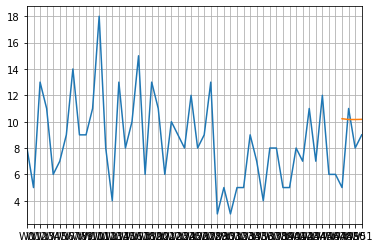

In [961]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data_raw.T[4][:])
plt.plot(x,actual_predictions[4])
plt.show()